
As of 24JAN20 17 this used TF r0.11.
I'm using the cloudml environment for python
type: source activate cloudml 
before running jupyter notebook

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import tensorflow as tf
import time

from datasets import dataset_utils

# Main slim library
slim = tf.contrib.slim

# Reading Data with TF-Slim
<a id='ReadingTFSlimDatasets'></a>

Reading data with TF-Slim has two main components: A
[Dataset](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/slim/python/slim/data/dataset.py) and a 
[DatasetDataProvider](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/slim/python/slim/data/dataset_data_provider.py). The former is a descriptor of a dataset, while the latter performs the actions necessary for actually reading the data. Lets look at each one in detail:


## Dataset
A TF-Slim
[Dataset](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/slim/python/slim/data/dataset.py)
contains descriptive information about a dataset necessary for reading it, such as the list of data files and how to decode them. It also contains metadata including class labels, the size of the train/test splits and descriptions of the tensors that the dataset provides. For example, some datasets contain images with labels. Others augment this data with bounding box annotations, etc. The Dataset object allows us to write generic code using the same API, regardless of the data content and encoding type.

TF-Slim's Dataset works especially well when the data is stored as a (possibly sharded)
[TFRecords file](https://www.tensorflow.org/versions/r0.10/how_tos/reading_data/index.html#file-formats), where each record contains a [tf.train.Example protocol buffer](https://github.com/tensorflow/tensorflow/blob/r0.10/tensorflow/core/example/example.proto).
TF-Slim uses a consistent convention for naming the keys and values inside each Example record. 

## DatasetDataProvider

A
[DatasetDataProvider](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/slim/python/slim/data/dataset_data_provider.py) is a class which actually reads the data from a dataset. It is highly configurable to read the data in various ways that may make a big impact on the efficiency of your training process. For example, it can be single or multi-threaded. If your data is sharded across many files, it can read each files serially, or from every file simultaneously.

## Demo: The Flowers Dataset

For convenience, we've include scripts to convert several common image datasets into TFRecord format and have provided
the Dataset descriptor files necessary for reading them. We demonstrate how easy it is to use these dataset via the Flowers dataset below.

### Download the Flowers Dataset
<a id='DownloadFlowers'></a>

We've made available a tarball of the Flowers dataset which has already been converted to TFRecord format.

In [6]:
import tensorflow as tf
from datasets import dataset_utils

#url = "http://download.tensorflow.org/data/flowers.tar.gz"
#flowers_data_dir = '/Volumes/LZD1601/training_data_kelpnokelp/benthoz2015_99patch'
flowers_data_dir = '/Users/opizarro/training_data_kelpnokelp'
#if not tf.gfile.Exists(flowers_data_dir):
#    tf.gfile.MakeDirs(flowers_data_dir)

#dataset_utils.download_and_uncompress_tarball(url, flowers_data_dir) 

### Display some of the data.

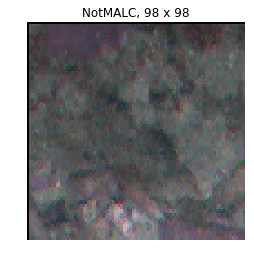

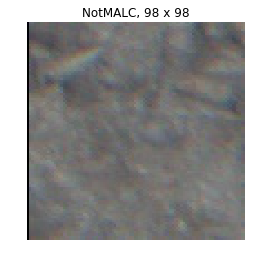

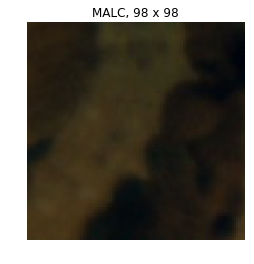

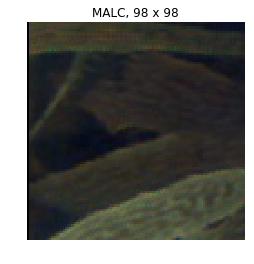

In [7]:
from datasets import kelp
import tensorflow as tf

slim = tf.contrib.slim

with tf.Graph().as_default(): 
    dataset = kelp.get_split('train', flowers_data_dir)
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=1)
    image, label = data_provider.get(['image', 'label'])
    
    with tf.Session() as sess:    
        with slim.queues.QueueRunners(sess):
            for i in xrange(4):
                np_image, np_label = sess.run([image, label])
                height, width, _ = np_image.shape
                class_name = name = dataset.labels_to_names[np_label]
                
                plt.figure()
                plt.imshow(np_image)
                plt.title('%s, %d x %d' % (name, height, width))
                plt.axis('off')
                plt.show()

# Using pre-trained models
<a id='Pretrained'></a>

Neural nets work best when they have many parameters, making them very flexible function approximators.
However, this  means they must be trained on big datasets. Since this process is slow, we provide various pre-trained models - see the list [here](https://github.com/tensorflow/models/tree/master/slim#pre-trained-models).


You can either use these models as-is, or you can perform "surgery" on them, to modify them for some other task. For example, it is common to "chop off" the final pre-softmax layer, and replace it with a new set of weights corresponding to some new set of labels. You can then quickly fine tune the new model on a small new dataset. We illustrate this below, using inception-v1 as the base model. While models like Inception V3 are more powerful, Inception V1 is used for speed purposes.


### Download the Inception V1 checkpoint




In [18]:
from datasets import dataset_utils

url = "http://download.tensorflow.org/models/inception_v1_2016_08_28.tar.gz"
checkpoints_dir = '/tmp/checkpoints_kelp'

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

>> Downloading inception_v1_2016_08_28.tar.gz 100.0%
Successfully downloaded inception_v1_2016_08_28.tar.gz 24642554 bytes.



### Apply Pre-trained model to Images.

We have to convert each image to the size expected by the model checkpoint.
There is no easy way to determine this size from the checkpoint itself.
So we use a preprocessor to enforce this.

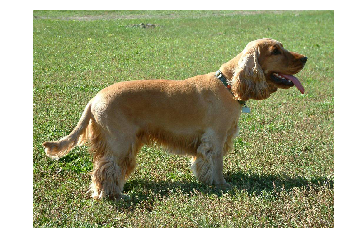

Probability 0.45% => [cocker spaniel, English cocker spaniel, cocker]
Probability 0.23% => [Sussex spaniel]
Probability 0.10% => [Irish setter, red setter]
Probability 0.04% => [Welsh springer spaniel]
Probability 0.03% => [clumber, clumber spaniel]


In [15]:
import numpy as np
import os
import tensorflow as tf
import urllib2

from datasets import imagenet
from nets import inception
from preprocessing import inception_preprocessing

slim = tf.contrib.slim

batch_size = 3
image_size = inception.inception_v1.default_image_size

with tf.Graph().as_default():
    url = 'https://upload.wikimedia.org/wikipedia/commons/7/70/EnglishCockerSpaniel_simon.jpg'
    image_string = urllib2.urlopen(url).read()
    image = tf.image.decode_jpeg(image_string, channels=3)
    processed_image = inception_preprocessing.preprocess_image(image, image_size, image_size, is_training=False)
    processed_images  = tf.expand_dims(processed_image, 0)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(processed_images, num_classes=1001, is_training=False)
    probabilities = tf.nn.softmax(logits)
    
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'inception_v1.ckpt'),
        slim.get_model_variables('InceptionV1'))
    
    with tf.Session() as sess:
        init_fn(sess)
        np_image, probabilities = sess.run([image, probabilities])
        probabilities = probabilities[0, 0:]
        sorted_inds = [i[0] for i in sorted(enumerate(-probabilities), key=lambda x:x[1])]
        
    plt.figure()
    plt.imshow(np_image.astype(np.uint8))
    plt.axis('off')
    plt.show()

    names = imagenet.create_readable_names_for_imagenet_labels()
    for i in range(5):
        index = sorted_inds[i]
        print('Probability %0.2f%% => [%s]' % (probabilities[index], names[index]))

In [ ]:
Batch loading definition (needed)

In [19]:
from preprocessing import inception_preprocessing
import tensorflow as tf

slim = tf.contrib.slim


def load_batch(dataset, batch_size=32, height=299, width=299, is_training=False):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32,
        common_queue_min=8)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Preprocess image for usage by Inception.
    image = inception_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=1,
          capacity=2 * batch_size)
    
    return images, images_raw, labels

### Fine-tune the model on a different set of labels.

We will fine tune the inception model on the Flowers dataset.

In [21]:
# Note that this may take several minutes.

import os

from datasets import kelp
from nets import inception
from preprocessing import inception_preprocessing

slim = tf.contrib.slim
image_size = inception.inception_v1.default_image_size


def get_init_fn():
    """Returns a function run by the chief worker to warm-start the training."""
    checkpoint_exclude_scopes=["InceptionV1/Logits", "InceptionV1/AuxLogits"]
    
    exclusions = [scope.strip() for scope in checkpoint_exclude_scopes]

    variables_to_restore = []
    for var in slim.get_model_variables():
        excluded = False
        for exclusion in exclusions:
            if var.op.name.startswith(exclusion):
                excluded = True
                break
        if not excluded:
            variables_to_restore.append(var)

    return slim.assign_from_checkpoint_fn(
      os.path.join(checkpoints_dir, 'inception_v1.ckpt'),
      variables_to_restore)


train_dir = '/tmp/inception_finetuned_kelp/'

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = kelp.get_split('train', flowers_data_dir)
    images, _, labels = load_batch(dataset, height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(images, num_classes=dataset.num_classes, is_training=True)
        
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()

    # Create some summaries to visualize the training process:
    tf.scalar_summary('losses/Total Loss', total_loss)
  
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    train_op = slim.learning.create_train_op(total_loss, optimizer)
    
    # Run the training:
    final_loss = slim.learning.train(
        train_op,
        logdir=train_dir,
        init_fn=get_init_fn(),
        number_of_steps=1000)
        
  
print('Finished training. Last batch loss %f' % final_loss)

INFO:tensorflow:Starting Session.
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global step 6: loss = 0.4364 (15.16 sec/step)
INFO:tensorflow:global step 7: loss = 0.7088 (10.38 sec/step)
INFO:tensorflow:global step 8: loss = 0.5428 (10.70 sec/step)
INFO:tensorflow:global step 9: loss = 0.8576 (9.66 sec/step)
INFO:tensorflow:global step 10: loss = 0.4866 (10.31 sec/step)
INFO:tensorflow:global step 11: loss = 0.5399 (10.14 sec/step)
INFO:tensorflow:global step 12: loss = 0.7045 (10.20 sec/step)
INFO:tensorflow:global step 13: loss = 0.8094 (10.09 sec/step)
INFO:tensorflow:global step 14: loss = 0.9504 (10.09 sec/step)
INFO:tensorflow:global step 15: loss = 0.6513 (10.28 sec/step)
INFO:tensorflow:global step 16: loss = 0.7080 (10.71 sec/step)
INFO:tensorflow:global step 17: loss = 0.5008 (13.45 sec/step)
INFO:tensorflow:global step 18: loss = 0.6944 (11.00 sec/step)
INFO:tensorflow:global step 19: loss = 0.5849 (10.91 sec/step)
INFO:tensorflow:globa

Finished training. Last batch loss 0.477946


### Apply fine tuned model to some images.

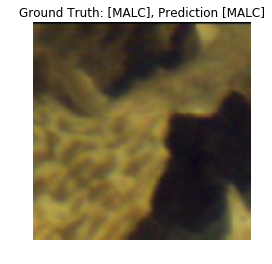

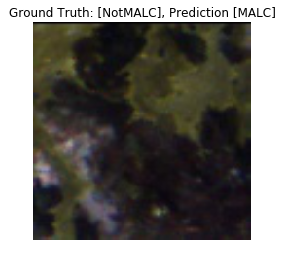

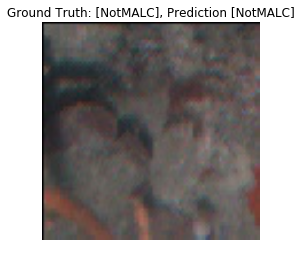

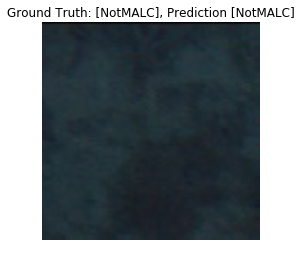

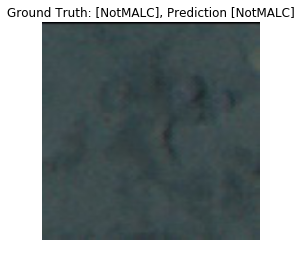

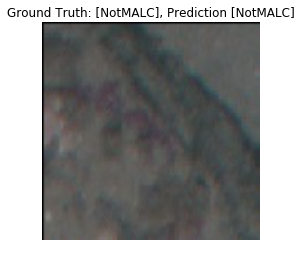

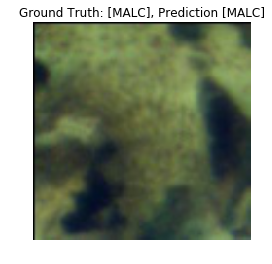

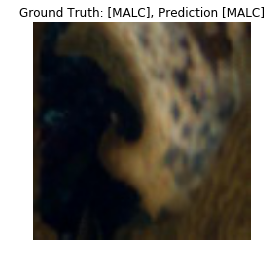

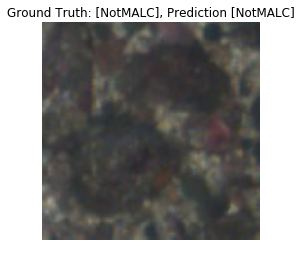

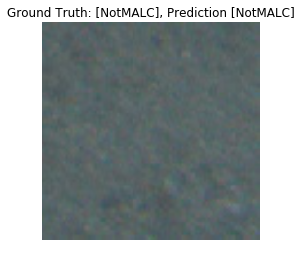

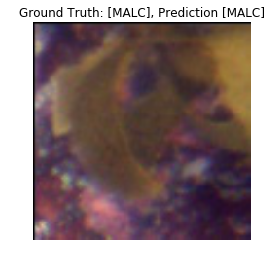

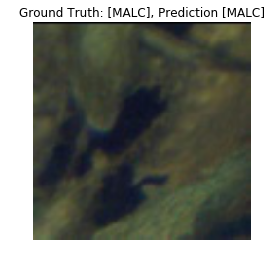

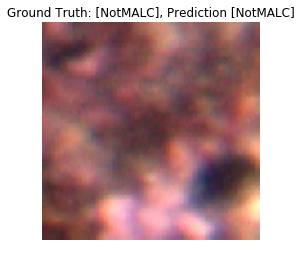

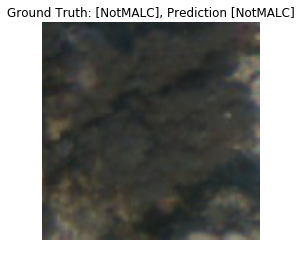

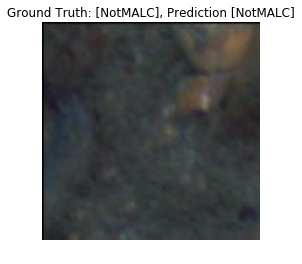

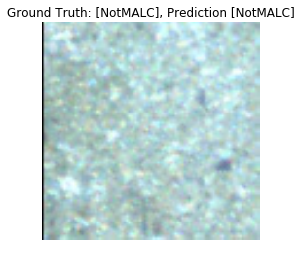

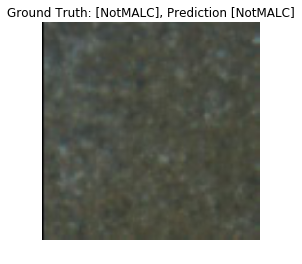

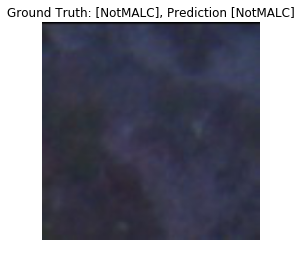

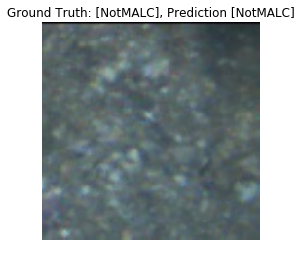

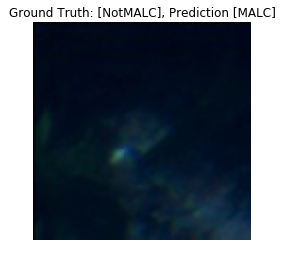

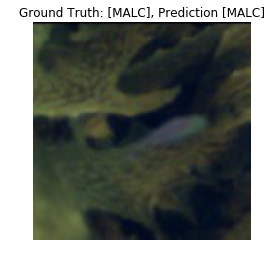

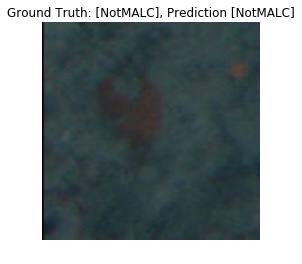

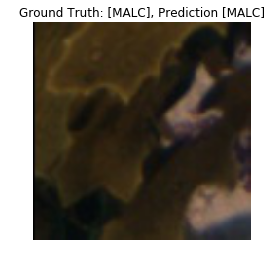

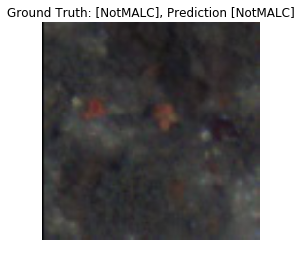

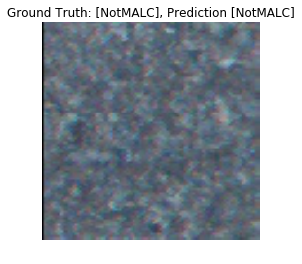

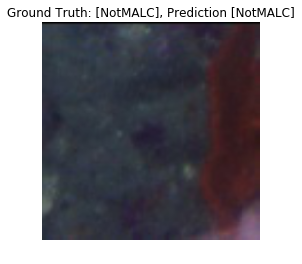

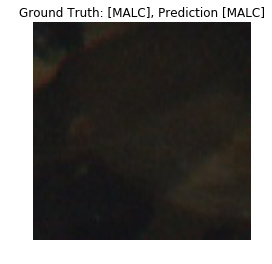

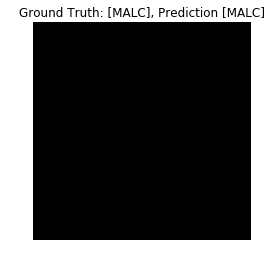

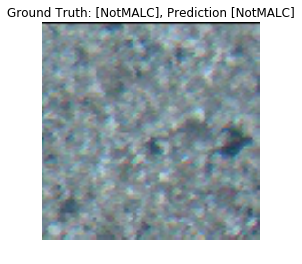

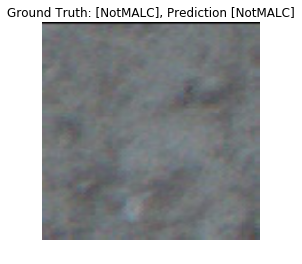

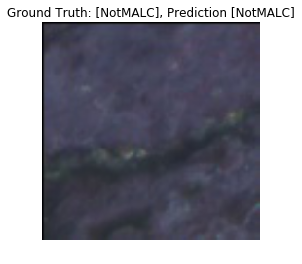

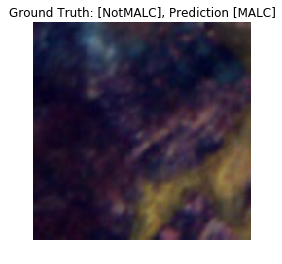

IndexError: index 32 is out of bounds for axis 0 with size 32

In [24]:
import numpy as np
import tensorflow as tf
from datasets import kelp
from nets import inception

slim = tf.contrib.slim

image_size = inception.inception_v1.default_image_size
batch_size = 100

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = kelp.get_split('train', flowers_data_dir)
    images, images_raw, labels = load_batch(dataset, height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(images, num_classes=dataset.num_classes, is_training=True)

    probabilities = tf.nn.softmax(logits)
    
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    init_fn = slim.assign_from_checkpoint_fn(
      checkpoint_path,
      slim.get_variables_to_restore())
    
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.initialize_local_variables())
            init_fn(sess)
            np_probabilities, np_images_raw, np_labels = sess.run([probabilities, images_raw, labels])
    
            for i in xrange(batch_size): 
                image = np_images_raw[i, :, :, :]
                true_label = np_labels[i]
                predicted_label = np.argmax(np_probabilities[i, :])
                predicted_name = dataset.labels_to_names[predicted_label]
                true_name = dataset.labels_to_names[true_label]
                
                plt.figure()
                plt.imshow(image.astype(np.uint8))
                plt.title('Ground Truth: [%s], Prediction [%s]' % (true_name, predicted_name))
                plt.axis('off')
                plt.show()